In [9]:
!pip install pathlib matplotlib pandas seaborn tensorflow


In [94]:
import pathlib 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers

In [3]:
!pip install scikit-learn


In [114]:
import os
import numpy as np
import cv2  # OpenCV for image handling
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

# Paths
image_folder = "data2"  # Folder containing subfolders for each class

# Parameters
IMG_SIZE = 256  # Resize images to this size
NUM_CLASSES = 3  # Adjust according to your dataset

# Function to resize and pad the image to maintain the aspect ratio
def resize_with_padding(image, target_size=(IMG_SIZE, IMG_SIZE), color=(0, 0, 0)):
    old_size = image.shape[:2]  # (height, width)
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))
    
    # Resize the image
    resized_image = cv2.resize(image, new_size)
    
    # Calculate padding
    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    # Pad the image to make it the target size
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return padded_image

# 1. Load Images and Labels
images = []
labels = []

# Go through each subfolder in the image folder
for label_folder in os.listdir(image_folder):
    label_path = os.path.join(image_folder, label_folder)
    
    # Ensure it's a folder and the name is numeric (to avoid files like .ipynb_checkpoints)
    if not os.path.isdir(label_path) or not label_folder.isdigit():
        continue
    
    # Use the folder name as the label (assuming folder names are class indices)
    label = int(label_folder)  # Convert folder name to an integer for label
    
    # Loop through each image file in the subfolder
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name)
        
        # Load image
        image = cv2.imread(image_path)
        
        if image is None:
            continue  # Skip if the image can't be opened
        
        # Apply padding to resize the image with the target size while maintaining aspect ratio
        image = resize_with_padding(image, target_size=(IMG_SIZE, IMG_SIZE))
        
        # Normalize the image
        image = image.astype("float") / 255.0
        
        # Convert image to array
        image = img_to_array(image)
        
        # Append to the lists
        images.append(image)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# 2. Preprocess Labels
# If you have categorical labels, use to_categorical to one-hot encode them
labels = to_categorical(labels, num_classes=NUM_CLASSES)

# 3. Split into Training and Testing Data and Shuffle
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0, shuffle=True)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training data shape: (152, 256, 256, 3)
Testing data shape: (38, 256, 256, 3)
Training labels shape: (152, 3)
Testing labels shape: (38, 3)


In [106]:
import matplotlib.pyplot as plt

# Function to display a few images from the dataset
def display_images(images, labels, num_images=5):
    plt.figure(figsize=(256, 256))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i]
        label = np.argmax(labels[i])  # Get the class label from one-hot encoding
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')  # Turn off axis
    plt.show()

# Call the display function on a sample of the training images
display_images(X_train, y_train, num_images=5)


In [100]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# -------------------------------
# 1. Set Parameters
# -------------------------------
IMG_HEIGHT, IMG_WIDTH = 256, 256# Image dimensions
BATCH_SIZE = 32                   # Number of samples per batch
NUM_CLASSES = 3                   # Number of output classes
EPOCHS = 25                       # Maximum number of epochs
LEARNING_RATE = 1e-1             # Learning rate for the optimizer

# -------------------------------
# 2. Load and Preprocess Data
# -------------------------------
# Assuming you already have the images (x_train, x_test) and labels (y_train, y_test)
# from the data preprocessing code provided earlier
# x_train, x_test, y_train, y_test are already split, so you can continue with training.

# Convert one-hot encoded labels back to integers for class weight calculation
y_train_int = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels
y_test_int = np.argmax(y_test, axis=1)    # Convert one-hot to integer labels

# -------------------------------
# 3. Handle Class Imbalance
# -------------------------------
# Compute class weights if your data is imbalanced
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int  # Pass integer labels to compute class weights
)
class_weights = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights}")

# -------------------------------
# 4. Build the Model
# -------------------------------

model = Sequential([
    # First Convolutional Block
    Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Second Convolutional Block
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Third Convolutional Block
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    # BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Global Average Pooling
    GlobalAveragePooling2D(),

    # Fully Connected Layers with Dropout
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    # Dropout(0.5),

    # Output Layer
    Dense(NUM_CLASSES, activation='softmax')
])

# -------------------------------
# 5. Compile the Model
# -------------------------------

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------------------
# 6. Define Callbacks
# -------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# -------------------------------
# 7. Train the Model
# -------------------------------
history = model.fit(
    X_train, y_train,  # Use your preprocessed data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    class_weight=class_weights,  # Handle class imbalance
    callbacks=[early_stopping]   # Early stopping to prevent overfitting
)

# -------------------------------
# 8. Evaluate the Model
# -------------------------------
test_loss, test_accuracy = model.evaluate(
    X_test, y_test,
    batch_size=BATCH_SIZE,
    verbose=1
)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# -------------------------------
# Optional: Save the Model
# -------------------------------
# model.save('cnn_model.h5')


Class Weights: {0: 0.9212121212121213, 1: 0.9559748427672956, 2: 1.1515151515151516}


C:\Users\91820\Desktop\deep learnin\ImageClassification\imageclassification\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.2678 - loss: 360886.6250 - val_accuracy: 0.2895 - val_loss: 44689.6016
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.2669 - loss: 2761.0806 - val_accuracy: 0.2895 - val_loss: 1.2644
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4385 - loss: 1.2638 - val_accuracy: 0.3684 - val_loss: 1.1444
Epoch 4/25
3/5 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.3229 - loss: 1.1776

KeyboardInterrupt: 

'





2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


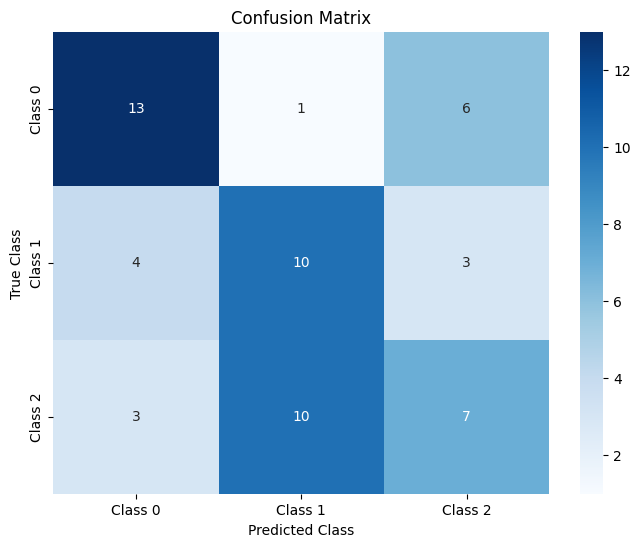

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.65      0.65      0.65        20
     Class 1       0.48      0.59      0.53        17
     Class 2       0.44      0.35      0.39        20

    accuracy                           0.53        57
   macro avg       0.52      0.53      0.52        57
weighted avg       0.52      0.53      0.52        57



In [78]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)          # True labels in categorical format

# Class names (replace with actual class names if available)
class_names = [f"Class {i}" for i in range(NUM_CLASSES)]

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix for visual inspection
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

# 2. Classification Report
# This provides precision, recall, F1-score, and support for each class
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


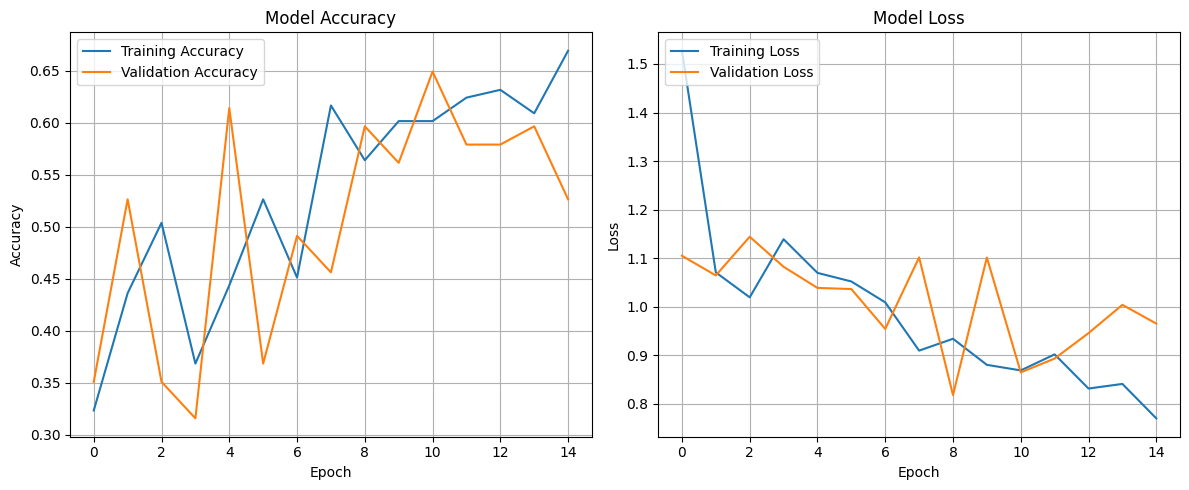

In [80]:
import matplotlib.pyplot as plt

# Plotting function
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with your history object
plot_training_history(history)


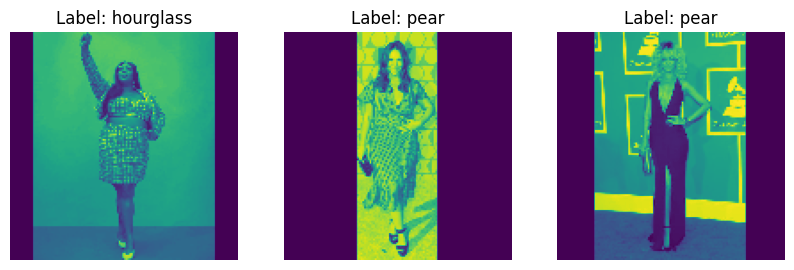

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already loaded your images and labels as `images` and `labels`
# and that `labels_dict` contains the image file names and their corresponding labels

# Let's display a few images from your dataset
def show_images_with_labels(images, labels, label_dict, num_images=5):
    # Set up the plot
    plt.figure(figsize=(10, 10))
    
    # Choose a random subset of images to display
    indices = np.random.choice(range(len(images)), num_images, replace=False)
    
    for i, idx in enumerate(indices):
        # Subplot configuration
        plt.subplot(1, num_images, i + 1)
        
        # Get the image and its corresponding label
        img = images[idx]
        label = np.argmax(labels[idx])  # For categorical labels
        
        # Inverse normalization if necessary (optional)
        # img = (img * 255).astype(np.uint8) 
        
        # Display the image
        plt.imshow(img)
        plt.title(f"Label: {label_dict[label]}")
        plt.axis('off')  # Hide axes

    # Show the plot
    plt.show()

# Assuming label_dict maps label indices to human-readable class names
label_dict = {0: 'pear', 1: 'inverted triangle', 2: 'hourglass', 4: 'banana', 5: 'apple'}  # Adjust according to your dataset

# Display 5 random images with their labels
show_images_with_labels(X_train, y_train, label_dict, num_images=3)


In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import Input  # Optional if using Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
# from tensorflow.keras.layers.experimental import preprocessing

In [88]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation , RandomZoom, RandomContrast,RandomTranslation,RandomBrightness

# Data Augmentation Layers
data_augmentation = Sequential([
    RandomFlip("horizontal"),          # Flip horizontally
    RandomRotation(0.1),               # Small rotation
    RandomZoom(0.1),                   # Slight zoom
    RandomTranslation(0.1, 0.1),       # Translate slightly in both directions
    RandomContrast(0.2),               # Contrast adjustment
    RandomBrightness(0.2)  
])



In [90]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization


In [ ]:
model = Sequential([
     # tf.keras.layers.Input(shape=(256, 256, 3)),
     # data_augmentation,
     # Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
     Conv2D(filters=84, kernel_size=(3,3), padding="same", activation="relu"),
     MaxPooling2D((2, 2)),

     Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    

     Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
     # Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     # Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     # MaxPooling2D((2, 2)),
    
     # Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     # Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     # Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
     MaxPooling2D((2, 2)),

     Flatten(),
     Dense(128, activation="relu"),
     Dense(32, activation="relu"),
     Dense(3, activation="softmax"),
])

# 6. Compile the Model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# 7. Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

# 8. Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.4130 - loss: 8.3059 - val_accuracy: 0.5789 - val_loss: 1.0187
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.5674 - loss: 0.9564 - val_accuracy: 0.6842 - val_loss: 0.9391
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.6756 - loss: 0.7584 - val_accuracy: 0.6842 - val_loss: 0.8878
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.7514 - loss: 0.5551 - val_accuracy: 0.6053 - val_loss: 1.1198
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8427 - loss: 0.4478 - val_accuracy: 0.6316 - val_loss: 0.8810
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8371 - loss: 0.3534 - val_accuracy: 0.6579 - val_loss: 0.9659
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.9103 - loss: 0.2657 - val_accuracy: 0.6842 - val_loss: 1.0145
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9468 - loss: 0.1624 - val_accuracy: 0.6316 - val_loss: 1.2144
Epoch 9/

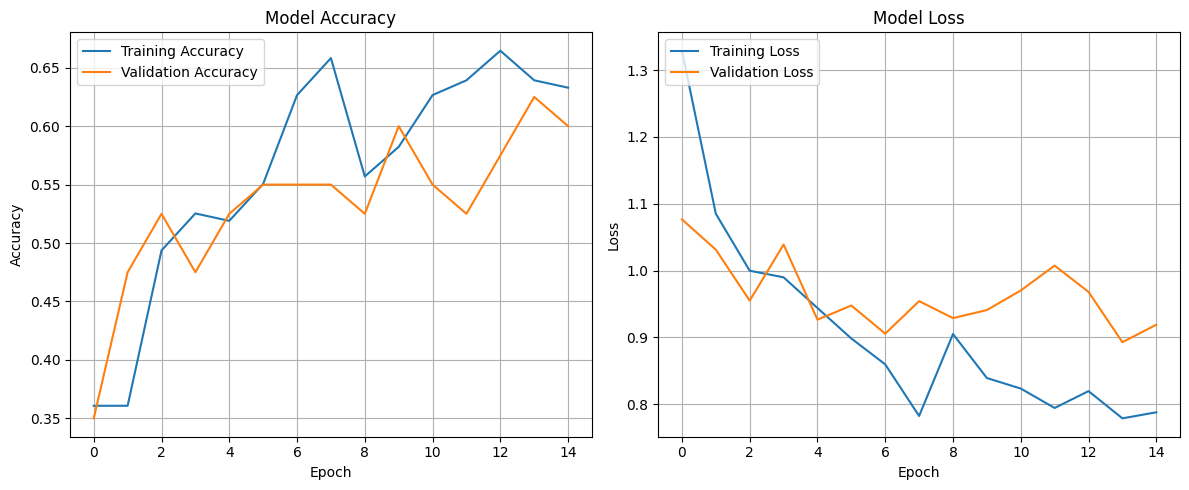

In [32]:
import matplotlib.pyplot as plt

# Plotting function
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Call the function with your history object
plot_training_history(history)

In [54]:
X_train.shape


(156, 128, 128, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define Data Augmentation as the first layer in the model
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# Load ResNet50 pre-trained on ImageNet, excluding the top fully connected layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Keep ResNet50 in inference mode
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)  # Add dropout layer
x = Dense(512, activation="relu")(x)
output = Dense(7, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Prepare the data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping, checkpoint])

# Evaluate the model on test data
loss, accuracy = model.evaluate(val_dataset)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Epoch 1/15


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 3), output.shape=(None, 7)

In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import ResNet101  # Import ResNet101
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define Data Augmentation as the first layer in the model
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# Load ResNet101 pre-trained on ImageNet, excluding the top fully connected layer
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(256, 256, 3))  # Update input shape

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Construct the model
inputs = tf.keras.Input(shape=(256, 256, 3))  # Update input shape here as well
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Keep ResNet101 in inference mode
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
output = Dense(3, activation="softmax")(x)

# Create the final model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Prepare the data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping, checkpoint])

# Evaluate the model on test data
loss, accuracy = model.evaluate(val_dataset)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4049 - loss: 1.1079 - val_accuracy: 0.2250 - val_loss: 1.1169
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3776 - loss: 1.1247 - val_accuracy: 0.4250 - val_loss: 1.1314
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3629 - loss: 1.1229 - val_accuracy: 0.3750 - val_loss: 1.0861
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.3294 - loss: 1.1136 - val_accuracy: 0.4000 - val_loss: 1.1183
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4353 - loss: 1.0758 - val_accuracy: 0.4000 - val_loss: 1.0873
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3401 - loss: 1.0905 - val_accuracy: 0.4000 - val_loss: 1.0694
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3693 - loss: 1.0622 - val_accuracy: 0.4000 - val_loss: 1.1058
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.3160 - loss: 1.1087 - val_accuracy: 0.4250 - val_loss: 1.0739
Epoch 9/

In [158]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Sequential

# Data Augmentation
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# Load ResNet34 (using ResNet50 as a substitute since ResNet34 isn't directly available)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
output = Dense(3, activation="softmax")(x)  # Adjust number of classes

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# Prepare the data (assuming X_train, y_train, X_test, y_test are defined)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=1000).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[early_stopping, checkpoint])

# Evaluate the model
loss, accuracy = model.evaluate(val_dataset)
print(f"Test accuracy: {accuracy * 100:.2f}%")


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.2857 - loss: 1.1807 - val_accuracy: 0.5000 - val_loss: 1.0816
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3795 - loss: 1.1260 - val_accuracy: 0.4000 - val_loss: 1.0704
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3932 - loss: 1.0902 - val_accuracy: 0.3750 - val_loss: 1.0884
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.3405 - loss: 1.0848 - val_accuracy: 0.4750 - val_loss: 1.0698
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4210 - loss: 1.0722 - val_accuracy: 0.4500 - val_loss: 1.0645
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4405 - loss: 1.0593 - val_accuracy: 0.4750 - val_loss: 1.0621
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4865 - loss: 1.0430 - val_accuracy: 0.4750 - val_loss: 1.0648
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4617 - loss: 1.0483 - val_accuracy: 0.4750 - val_loss: 1.0756
Epoch 9/

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Parameters
input_shape = (256, 256, 3)
num_classes =  6 # Adjust based on the number of body shape categories

# Load the InceptionV3 model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to retain pre-trained weights
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [133]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add the shortcut (skip connection)
    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet16(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Add residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs =  Dense(3, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

# Model parameters
input_shape = (128, 128, 3)  # Based on your preference
num_classes = 3 # Update this if needed

# Build model
model = ResNet16(input_shape=input_shape, num_classes=num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
# model.summary()

# Load data (replace with your dataset loading code)
# Assuming `train_images`, `train_labels`, `val_images`, `val_labels` are available

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

# Save model
# model.save("resnet16_model.h5")


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 9s/step - accuracy: 0.4109 - loss: 1.3156 - val_accuracy: 0.4000 - val_loss: 1.8142
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.5537 - loss: 0.8187 - val_accuracy: 0.4000 - val_loss: 4.6239
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 42s 8s/step - accuracy: 0.6483 - loss: 0.7527 - val_accuracy: 0.4000 - val_loss: 6.9628
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.7129 - loss: 0.6545 - val_accuracy: 0.2750 - val_loss: 4.1053
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6751 - loss: 0.6286 - val_accuracy: 0.1750 - val_loss: 2.4732
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.7215 - loss: 0.6336 - val_accuracy: 0.1750 - val_loss: 1.5590
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.7756 - loss: 0.5440 - val_accuracy: 0.3750 - val_loss: 1.7253
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.7511 - loss: 0.5835 - val_accuracy: 0.3500 - val_loss: 1.7063
Epoch 9/